In [ ]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch import optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
n_classes = 100
embedding_dim = 100
latent_dim = 100

In [ ]:
batch_size = 100

dataset = dset.CIFAR100(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
print(len(dataset))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=2)
print(len(dataloader))

In [ ]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        input_dim = 100 + 100
        output_dim = 3072
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        c = c.view(-1,x.size(1))
        x = torch.cat([x,c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)

class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        input_dim = 3072 + 100
        output_dim = 1
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        c = c.view(-1,latent_dim)
        x = torch.cat([x, c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output.to(device)

discriminator = DiscriminatorModel()
generator = GeneratorModel()
discriminator.to(device)
generator.to(device)

GeneratorModel(
  (label_embedding): Embedding(10, 10)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [ ]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.00002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.00002)

loss = nn.BCELoss()
n_epochs = 10

[0/100]: loss_d: 0.442, loss_g: 3.117
[1/100]: loss_d: 0.566, loss_g: 1.387
[2/100]: loss_d: 0.458, loss_g: 2.351
[3/100]: loss_d: 0.303, loss_g: 2.775
Training Steps Completed:  499
4


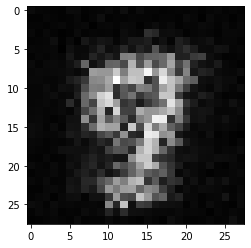

[4/100]: loss_d: 0.262, loss_g: 3.124
[5/100]: loss_d: 0.258, loss_g: 3.041
[6/100]: loss_d: 0.273, loss_g: 2.822
[7/100]: loss_d: 0.261, loss_g: 2.862
[8/100]: loss_d: 0.284, loss_g: 2.730
Training Steps Completed:  499
7


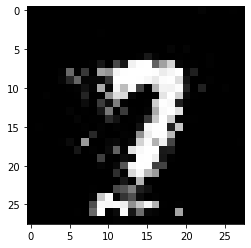

[9/100]: loss_d: 0.261, loss_g: 2.962
[10/100]: loss_d: 0.265, loss_g: 2.778
[11/100]: loss_d: 0.270, loss_g: 2.995
[12/100]: loss_d: 0.298, loss_g: 2.554
[13/100]: loss_d: 0.337, loss_g: 2.309
Training Steps Completed:  499
5


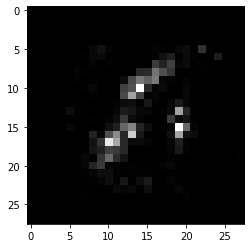

[14/100]: loss_d: 0.350, loss_g: 2.265


In [ ]:
for epoch_idx in range(n_epochs):
    G_loss = []
    D_loss = []
    for batch_idx, data_input in enumerate(data_loader):
         
        true_data = data_input[0].view(batch_size, 3072).to(device) # batch_size X 784
        digit_labels = data_input[1].to(device) # batch_size
        true_labels = torch.ones(batch_size).to(device)

        noise = torch.randn(batch_size,100).to(device)
        generated_data = generator(noise, fake_labels) # batch_size X 784

        # Discriminator
        
        discriminator_optimizer.zero_grad()

        discriminator_output_for_true_data = discriminator(true_data, digit_labels).view(batch_size)
        true_discriminator_loss = loss(discriminator_output_for_true_data, true_labels)

        discriminator_output_for_generated_data = discriminator(generated_data.detach(), fake_labels).view(batch_size)
        generator_discriminator_loss = loss(discriminator_output_for_generated_data, torch.zeros(batch_size).to(device))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        
        discriminator_loss.backward()
        discriminator_optimizer.step()

        D_loss.append(discriminator_loss.data.item())
        
        # Generator
        generator_optimizer.zero_grad()
        # It's a choice to generate the data again
        generated_data = generator(noise, fake_labels) # batch_size X 784
        discriminator_output_on_generated_data = discriminator(generated_data, fake_labels).view(batch_size)
        generator_loss = loss(discriminator_output_on_generated_data, true_labels)
        generator_loss.backward()
        generator_optimizer.step()
        
        G_loss.append(generator_loss.data.item())
        if ((batch_idx + 1)% 500 == 0 and (epoch_idx + 1)%5 == 0):
            print("Training Steps Completed: ", batch_idx)
            
            with torch.no_grad():
                noise = torch.randn(batch_size,100).to(device)
                fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)
                for x in generated_data:
                    print(fake_labels[0].item())
                    plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
                    plt.show()
                    break

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))